## Web Voyager

[WebVoyager](https://arxiv.org/abs/2401.13919) by He, et. al., is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard.

It works by viewing annotated browser screenshots for each turn, then choosing the next step to take. The agent architecture is a basic reasoning and action (ReAct) loop. 
The unique aspects of this agent are:
- It's usage of [Set-of-Marks](https://som-gpt4v.github.io/)-like image annotations to serve as UI affordances for the agent
- It's application in the browser by using tools to control both the mouse and keyboard

The overall design looks like the following:

<!-- ![Voyager Image](./img/web-voyager.excalidraw.png) -->
<img src="./img/web-voyager.excalidraw.png" width="50%">


## Configure environment

We will first set up LangSmith tracing. Though optional, this lets us inspect and debug agent's trajectory for a given input.

You can sign up at [smith.langchain.com](https://smith.langchain.com/) to get an API key.

In [1]:
%%capture --no-stderr
%pip install -U --quiet langgraph langsmith langchain_openai

In [2]:
# Optional: add tracing to visualize the agent trajectories
import os
from getpass import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Web-Voyager"
os.environ["LANGCHAIN_API_KEY"] = getpass("LANGCHAIN_API_KEY")
os.environ["OPENAI_API_KEY"] = getpass("OPENAI_API_KEY")

#### Install Agent requirements

The only additional requirement we have is the [playwright](https://playwright.dev/) browser. Uncomment and install below:

In [3]:
%pip install --upgrade --quiet  playwright > /dev/null
!playwright install

Note: you may need to restart the kernel to use updated packages.


In [4]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Define Graph State

The state provides the inputs to each node in the graph.

In our case, the agent will track the webpage object (within the browser), annotated images + bounding boxes, the user's initial request, and the messages containing the agent scratchpad, system prompt, and other information.


In [5]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

## Define tools

The agent has 6 simple tools:

1. Click (at labeled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)


We define them below here as functions:

In [6]:
import asyncio
import platform

### Click Tool

In [7]:
async def click(state: AgentState):
    # This function simulates a click on a specific bounding box within a web page.
    # It uses the coordinates provided by the bounding box to perform the click action.

    # Retrieve the current page object from the state dictionary
    page = state["page"]

    # Retrieve the click arguments from the state, which contains the index or ID
    # of the bounding box that needs to be clicked.
    click_args = state["prediction"]["args"]

    # If click_args is None or doesn't contain exactly one argument (ID of the bounding box),
    # return an error message indicating a failure in clicking the bounding box.
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"

    # Extract the bounding box ID from the click arguments.
    bbox_id = click_args[0]

    # Convert the bounding box ID to an integer, as it might be passed as a string.
    bbox_id = int(bbox_id)

    try:
        # Retrieve the bounding box coordinates from the state dictionary using the bbox_id.
        bbox = state["bboxes"][bbox_id]
    except Exception:
        # If there is an error retrieving the bounding box (e.g., the ID is invalid),
        # return an error message indicating that no bounding box was found for the given ID.
        return f"Error: no bbox for : {bbox_id}"

    # Extract the x and y coordinates from the bounding box data.
    x, y = bbox["x"], bbox["y"]

    # Perform a mouse click at the specified coordinates (x, y) on the page.
    await page.mouse.click(x, y)

    # The following TODO comment suggests that the functionality could be extended
    # to automatically parse downloaded PDFs, similar to what was described in a research paper.
    # This could improve the response format or extend the feature set.

    # Return a success message indicating that the click on the bounding box was successful.
    return f"Clicked {bbox_id}"

### Type Tool

In [8]:
async def type_text(state: AgentState):
    # This function simulates typing text into a specific web element on a page.
    # The element is identified by its bounding box coordinates.

    # Retrieve the current page object from the state dictionary.
    page = state["page"]

    # Retrieve the typing arguments from the state, which should contain:
    # 1) the bounding box ID where the text needs to be typed,
    # 2) the text content that needs to be typed.
    type_args = state["prediction"]["args"]

    # If the typing arguments are missing or do not contain exactly two items,
    # return an error message indicating a failure in typing.
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )

    # Extract the bounding box ID from the arguments.
    bbox_id = type_args[0]

    # Convert the bounding box ID to an integer, as it might be passed as a string.
    bbox_id = int(bbox_id)

    # Retrieve the bounding box coordinates from the state dictionary using the bbox_id.
    bbox = state["bboxes"][bbox_id]

    # Extract the x and y coordinates from the bounding box data.
    x, y = bbox["x"], bbox["y"]

    # Extract the text content to be typed from the arguments.
    text_content = type_args[1]

    # Perform a mouse click at the specified coordinates (x, y) on the page
    # to focus the text input element.
    await page.mouse.click(x, y)

    # Determine the appropriate keyboard shortcut for "Select All" based on the operating system.
    # On MacOS (Darwin), it's "Meta+A" (Command+A), and on other systems, it's "Control+A".
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"

    # Press the "Select All" shortcut to highlight any existing text in the input field.
    await page.keyboard.press(select_all)

    # Press "Backspace" to delete the selected text, clearing the input field.
    await page.keyboard.press("Backspace")

    # Type the new text content into the input field.
    await page.keyboard.type(text_content)

    # Press "Enter" to submit the input field.
    await page.keyboard.press("Enter")

    # Return a success message indicating that the text was typed and submitted successfully.
    return f"Typed {text_content} and submitted"


### Scroll

In [9]:
async def scroll(state: AgentState):
    # This function simulates a scroll action on a webpage, either on the entire window
    # or within a specific element identified by a bounding box.

    # Retrieve the current page object from the state dictionary.
    page = state["page"]

    # Retrieve the scroll arguments from the state, which should contain:
    # 1) The target where scrolling should occur (either "WINDOW" or a specific element ID),
    # 2) The direction of the scroll ("up" or "down").
    scroll_args = state["prediction"]["args"]

    # If the scroll arguments are missing or do not contain exactly two items,
    # return an error message indicating a failure to scroll.
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    # Extract the target (either "WINDOW" or an element ID) and the scroll direction from the arguments.
    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # If the target is "WINDOW", perform a scroll on the entire window.

        # Set a default scroll amount. This value can be adjusted based on the desired scroll speed.
        scroll_amount = 500

        # Determine the scroll direction: negative value for "up", positive for "down".
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )

        # Use the page's evaluate function to execute a JavaScript scroll command on the window.
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # If the target is a specific element, perform a scroll within that element.

        # Set a default scroll amount for element scrolling.
        scroll_amount = 200

        # Convert the target ID to an integer, as it might be passed as a string.
        target_id = int(target)

        # Retrieve the bounding box coordinates of the target element using the target ID.
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]

        # Determine the scroll direction: negative value for "up", positive for "down".
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )

        # Move the mouse to the location of the target element (x, y).
        await page.mouse.move(x, y)

        # Perform the scroll action within the element by simulating a mouse wheel scroll.
        await page.mouse.wheel(0, scroll_direction)

    # Return a success message indicating that the scroll action was performed.
    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


### Wait

In [10]:
async def wait(state: AgentState):
    # This function pauses execution for a specified duration (in seconds).
    
    # Define the amount of time to sleep (pause) in seconds.
    sleep_time = 5

    # Use asyncio.sleep to asynchronously pause execution for the specified duration.
    # This allows other tasks to run concurrently during the sleep period.
    await asyncio.sleep(sleep_time)

    # Return a message indicating the duration of the wait.
    return f"Waited for {sleep_time}s."


### Go Back

In [11]:
async def go_back(state: AgentState):
    # This function navigates the browser back to the previous page in the browser's history.

    # Retrieve the current page object from the state dictionary.
    page = state["page"]

    # Use the page object's go_back method to navigate to the previous page in the browser's history.
    await page.go_back()

    # Return a message indicating that the navigation was successful.
    # Since the page navigation is asynchronous, the exact URL after going back may not be immediately available.
    # If needed, await page.url for the actual URL after the page has finished loading.
    return f"Navigated back a page to {page.url}."


### Go Search

In [12]:

async def to_google(state: AgentState):
    # This function navigates the browser to the Google homepage.

    # Retrieve the current page object from the state dictionary.
    page = state["page"]

    # Use the page object's goto method to navigate to the specified URL.
    # In this case, it navigates to the Google homepage.
    await page.goto("https://www.google.com/")

    # Return a message indicating that the navigation was successful.
    return "Navigated to google.com."

## Define Agent

The agent is driven by a multi-modal model and decides the action to take for each step. It is composed of a few runnable objects:

1. A `mark_page` function to annotate the current page with bounding boxes
2. A prompt to hold the user question, annotated image, and agent scratchpad
3. GPT-4V to decide the next steps
4. Parsing logic to extract the action


Let's first define the annotation step:

### Function Purpose:
The `mark_page` function is designed to annotate a webpage by identifying interactive elements (like buttons, input fields, text areas, etc.) and marking them with numbered bounding boxes. This allows the agent to refer to these elements by their bounding box numbers when deciding actions, simplifying the interaction process.

In [13]:
import base64
from langchain_core.runnables import chain as chain_decorator

# Load the JavaScript code that handles marking the page with bounding boxes.
with open("./js/mark_page.js") as f:
    mark_page_script = f.read()

@chain_decorator
async def mark_page(page):
    # Execute the JavaScript to prepare the page for marking
    await page.evaluate(mark_page_script)
    
    # Attempt to run the `markPage` JavaScript function to get bounding boxes.
    # The function is retried multiple times in case the page is still loading.
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break  # If successful, exit the loop
        except Exception:
            # If there's an exception (likely because the page is still loading), wait for 3 seconds and retry.
            asyncio.sleep(3)

    # Take a screenshot of the page after marking it.
    screenshot = await page.screenshot()

    # Run JavaScript to remove the bounding boxes so they don't interfere with further interactions.
    await page.evaluate("unmarkPage()")
    
    # Return the screenshot (encoded in base64) and the bounding box information.
    return {
        "img": base64.b64encode(screenshot).decode(),  # Encode the screenshot as a base64 string.
        "bboxes": bboxes,  # Return the list of bounding boxes.
    }

#### Step-by-Step Explanation:

1. **Loading the JavaScript (`mark_page.js`)**:
   - The script `mark_page.js` is read into memory when the function is first loaded. This script contains the logic for finding and annotating the elements on the page.

2. **Decorator Usage (`@chain_decorator`)**:
   - The `@chain_decorator` decorator is applied to the `mark_page` function, likely indicating that this function is part of a series of actions or a workflow that the agent performs.

3. **Page Evaluation**:
   - The `page.evaluate(mark_page_script)` command executes the `mark_page.js` script in the context of the current webpage. This prepares the page for marking by initializing any necessary JavaScript code.

4. **Bounding Box Annotation Loop**:
   - The function attempts to run the `markPage()` function from the JavaScript code up to 10 times. This function is expected to return the bounding boxes of the identified elements on the page.
   - If the function fails (perhaps because the page hasn’t fully loaded), it waits for 3 seconds (`asyncio.sleep(3)`) before trying again.

5. **Taking a Screenshot**:
   - After successfully marking the elements, the function takes a screenshot of the page, capturing the visual state with the bounding boxes.

6. **Removing Annotations**:
   - The `unmarkPage()` function is called to remove the bounding boxes from the page. This ensures that the boxes don’t interfere with future interactions or clutter the page.

7. **Returning the Result**:
   - The function returns a dictionary containing two key pieces of information:
     - **`img`**: The screenshot of the page, encoded in base64, which can be used by the agent to visualize the page with the bounding boxes.
     - **`bboxes`**: The list of bounding boxes, which provides the locations of the annotated elements on the page.

#### Practical Use:
This function plays a critical role in reducing the complexity of web interactions for the agent. By annotating elements and providing a clear, visual reference, it allows the agent (driven by GPT-4V) to efficiently make decisions and refer to specific parts of the webpage without needing to process the entire page's content structure in detail.

The annotated image and bounding boxes are then used by the agent to decide which actions to take, such as clicking a button, typing into a text field, or scrolling a section of the page. The simplicity of referring to elements by their bounding box numbers significantly streamlines the interaction process.

### Agent definition

Now we'll compose this function with the prompt, llm and output parser to complete our agent.

In [14]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

#### 1. annotate Function
This asynchronous function annotates the webpage by invoking the `mark_page` function, which was previously defined to annotate the page with bounding boxes.

In [15]:
async def annotate(state):
    # Use mark_page to annotate the page and retry if necessary
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    
    # Return the updated state, merging the original state with the annotated page details
    return {**state, **marked_page}

- **`mark_page.with_retry().ainvoke(state["page"])`**: This line calls the `mark_page` function with retry logic, ensuring that if the page isn't ready on the first attempt, it will retry. It invokes the function asynchronously using `.ainvoke`.
- **`return {**state, **marked_page}`**: The function returns the updated `state`, which now includes the bounding boxes and the screenshot from the `mark_page` function.

#### 2. format_descriptions Function
This function formats the bounding box annotations into a human-readable string that describes each annotated element.

In [16]:

def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    
    # Create a formatted string listing all valid bounding boxes with their labels
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    
    # Return the updated state, including the formatted descriptions
    return {**state, "bbox_descriptions": bbox_descriptions}

- **`labels = []`**: Initializes a list to store descriptions of each bounding box.
- **`for i, bbox in enumerate(state["bboxes"]):`**: Iterates through each bounding box in the state.
- **`text = bbox.get("ariaLabel") or ""`**: Attempts to get an accessible label (`ariaLabel`) for the element. If it's not present, it defaults to an empty string.
- **`if not text.strip(): text = bbox["text"]`**: If the label is empty, it falls back to the visible text within the bounding box.
- **`el_type = bbox.get("type")`**: Retrieves the type of the HTML element (e.g., button, input).
- **`labels.append(f'{i} (<{el_type}/>): "{text}"')`**: Appends a formatted string that includes the bounding box index, element type, and the associated text.
- **`bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)`**: Combines all formatted strings into one block of text.
- **`return {**state, "bbox_descriptions": bbox_descriptions}`**: Returns the updated state with the bounding box descriptions.

#### 3. parse Function
This function parses the output from the LLM to extract the action that the agent should take.

In [17]:
def parse(text: str) -> dict:
    action_prefix = "Action: "
    
    # Check if the last line of the text starts with the action prefix
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    
    action_block = text.strip().split("\n")[-1]
    
    # Extract the action string by removing the action prefix
    action_str = action_block[len(action_prefix):]
    
    split_output = action_str.split(" ", 1)
    
    # Parse the action and action input from the output string
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    
    action = action.strip()
    
    # If there are inputs, clean them up and convert to a list
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    
    return {"action": action, "args": action_input}

- **`action_prefix = "Action: "`**: Defines the prefix that the LLM uses to indicate the action in its output.
- **`if not text.strip().split("\n")[-1].startswith(action_prefix):`**: Checks if the last line of the text starts with the action prefix. If not, it returns an error indicating that the output couldn't be parsed.
- **`action_block = text.strip().split("\n")[-1]`**: Extracts the last line of the LLM output, where the action is expected to be specified.
- **`action_str = action_block[len(action_prefix):]`**: Removes the action prefix to isolate the action string.
- **`split_output = action_str.split(" ", 1)`**: Splits the action string into the action name and the action input (if any).
- **`if len(split_output) == 1: action, action_input = split_output[0], None`**: If there's only one part, it's assumed to be the action without any inputs.
- **`if action_input is not None: action_input = [inp.strip().strip("[]") for inp in action_input.strip().split(";")]`**: If there's an input, it is split by semicolons into a list and cleaned up by stripping whitespace and brackets.
- **`return {"action": action, "args": action_input}`**: Returns the parsed action and arguments as a dictionary.

#### 4. prompt
The `prompt` variable is defined by pulling a template from the LangChain hub. This template likely contains a structured prompt designed for interacting with the LLM.


In [18]:
prompt = hub.pull("wfh/web-voyager")

- **`hub.pull("wfh/web-voyager")`**: This line fetches a pre-defined image prompt template named `"wfh/web-voyager"` from the LangChain hub. The prompt is used to generate instructions or questions for the LLM, guiding its behavior in interacting with the webpage.

### Agent pipeline

- This line initializes a language model instance using the `ChatOpenAI` class. 
- **`model="gpt-4o"`**: Specifies that the GPT-4 Vision model is being used, which means the model can handle both text and visual inputs (like images).
- **`max_tokens=4096`**: Sets the maximum number of tokens (words or symbols) the model can generate in response to a query.

In [19]:
llm = ChatOpenAI(model="gpt-4o", max_tokens=4096)

**Summary of the Pipeline:**

- **Annotation**: The webpage is first annotated with bounding boxes around relevant elements.
- **Formatting**: The bounding box information is formatted into a descriptive string.
- **Prompting**: This formatted information is passed through a prompt template designed for the LLM.
- **LLM Interaction**: The GPT-4 Vision model processes the input and generates a response.
- **Parsing**: The response from the LLM is parsed to extract the action and arguments that the agent should perform.
- **Assignment**: The entire process is encapsulated in the `agent` object, which handles the flow of data from one step to the next, ensuring that each piece of information is passed correctly through the pipeline.

In [20]:
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

## Define graph

We've created most of the important logic. We have one more function to define that will help us update the graph state after a tool is called.

In [21]:
import re

def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    
    # Retrieve the current scratchpad content from the state.
    old = state.get("scratchpad")
    
    if old:
        # If there is existing content in the scratchpad, extract the text.
        txt = old[0].content
        
        # Extract the last line of the existing scratchpad text.
        last_line = txt.rsplit("\n", 1)[-1]
        
        # Use a regular expression to find the step number in the last line.
        # This assumes that each line starts with a step number (e.g., "1.", "2.").
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        # If there is no existing scratchpad content, initialize it with a header.
        txt = "Previous action observations:\n"
        step = 1  # Start at step 1
    
    # Append the new observation to the scratchpad, incrementing the step number.
    txt += f"\n{step}. {state['observation']}"
    
    # Return the updated state, including the modified scratchpad.
    return {**state, "scratchpad": [SystemMessage(content=txt)]}


Now we can compose everything into a graph:

In [22]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph

# Initialize a StateGraph object that will manage the flow of the agent's actions.
# The graph will handle the transitions between different states (nodes) as the agent
# interacts with a webpage.
graph_builder = StateGraph(AgentState)

# Add the main 'agent' node to the graph. This node represents the agent's decision-making process.
# The agent will decide the next action to take based on the current state.
graph_builder.add_node("agent", agent)

# Set the 'agent' node as the entry point of the graph, meaning that the agent's decision-making process
# is the first thing that runs when the graph is executed.
graph_builder.set_entry_point("agent")

# Add a node for updating the scratchpad, which keeps track of the agent's actions and observations.
# This ensures that the agent can remember what it has done and use that information to inform future decisions.
graph_builder.add_node("update_scratchpad", update_scratchpad)

# Define an edge from the 'update_scratchpad' node back to the 'agent' node.
# After updating the scratchpad, the graph will return control to the agent to decide the next step.
graph_builder.add_edge("update_scratchpad", "agent")

# Define a dictionary of tools that the agent can use. Each tool corresponds to a specific action
# that the agent can take, such as clicking a button, typing text, scrolling a page, etc.
tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}

# Loop through each tool in the 'tools' dictionary and add it as a node in the graph.
# Each node represents an action that the agent can perform.

for node_name, tool in tools.items():
    # Add the tool as a node in the graph. 
    # The RunnableLambda wrapper is used to run the tool and capture its output.
    # The lambda function takes the output (usually a string) and maps it to the 'observation'
    # key in the AgentState, so the agent can use this observation in future decisions.
    graph_builder.add_node(
        node_name,
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )

    # Define an edge from the tool node to the 'update_scratchpad' node.
    # This ensures that after performing any action, the agent will update its scratchpad with
    # the new observation, and then return to the agent node to decide the next action.
    graph_builder.add_edge(node_name, "update_scratchpad")

# Define a function that selects the next tool or action based on the agent's decision.
# This function is called after the agent node completes, and it determines where the graph
# should transition next.

def select_tool(state: AgentState):
    # Extract the action that the agent decided to take from the state.
    action = state["prediction"]["action"]
    
    # If the action is "ANSWER", it means the agent has completed its task and the process should end.
    if action == "ANSWER":
        return END
    
    # If the action is "retry", it indicates the agent wants to retry its decision-making process.
    # The graph will return to the 'agent' node to decide the next action.
    if action == "retry":
        return "agent"
    
    # For any other action, return the action name. The graph will transition to the corresponding tool node.
    return action

# Add conditional edges to the 'agent' node based on the output of the 'select_tool' function.
# These edges control the flow of the graph, allowing it to dynamically choose the next node
# based on the agent's decisions.
graph_builder.add_conditional_edges("agent", select_tool)

app = graph_builder.compile()

## Visualize the Graph

We can also convert a graph class into Mermaid syntax.

In [23]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([__start__]):::first
	agent(agent)
	update_scratchpad(update_scratchpad)
	Click(Click)
	Type(Type)
	Scroll(Scroll)
	Wait(Wait)
	GoBack(GoBack)
	Google(Google)
	__end__([__end__]):::last
	Click --> update_scratchpad;
	GoBack --> update_scratchpad;
	Google --> update_scratchpad;
	Scroll --> update_scratchpad;
	Type --> update_scratchpad;
	Wait --> update_scratchpad;
	__start__ --> agent;
	update_scratchpad --> agent;
	agent -.-> update_scratchpad;
	agent -.-> Click;
	agent -.-> Type;
	agent -.-> Scroll;
	agent -.-> Wait;
	agent -.-> GoBack;
	agent -.-> Google;
	agent -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



#### PNG
If preferred, we could render the Graph into a .png. Here we could use three options:

- Using Mermaid.ink API (does not require additional packages)
- Using Mermaid + Pyppeteer (requires pip install pyppeteer)
- Using graphviz (which requires pip install graphviz)

By default, `draw_mermaid_png()` uses Mermaid.Ink's API to generate the diagram.

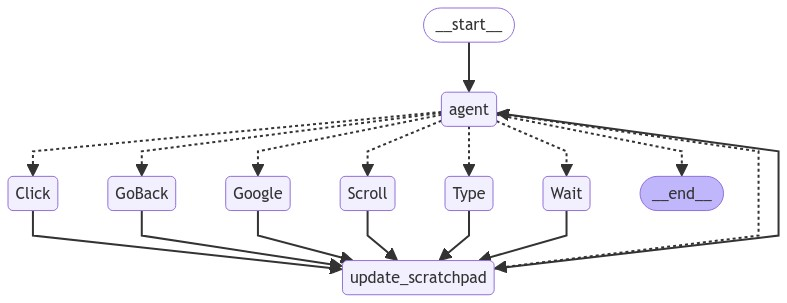

In [24]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run agent

Now that we've created the whole agent executor, we can run it on a few questions! We'll start our browser at "google.com" and then let it control the rest.

Below is a helper function to help print out the steps to the notebook (and display the intermediate screenshots).

In [27]:
from IPython import display
from playwright.async_api import async_playwright
import base64

# Start an instance of Playwright for browser automation.
# We use async_playwright() for an asynchronous session, which allows us to control the browser asynchronously.
browser = await async_playwright().start()

# Launch a Chromium browser instance with headless mode disabled (headless=False),
# meaning you can see the browser window as it operates. This is useful for debugging
# or observing the agent's actions in real time.
browser = await browser.chromium.launch(headless=False, args=None)

# Open a new tab in the browser and navigate to Google's homepage.
page = await browser.new_page()
_ = await page.goto("https://www.google.com")

# Define an asynchronous function to interact with the agent.
# - `question`: The input query that the agent will try to answer.
# - `page`: The Playwright page object, representing the current browser tab.
# - `max_steps`: The maximum number of actions the agent can take before stopping (to prevent infinite loops).
async def call_agent(question: str, page, max_steps: int = 150):
    # Initialize an event stream from the agent's graph.
    # The stream processes the agent's actions and observations step by step.
    event_stream = app.astream(
        {
            "page": page,            # The current browser page where the agent will operate.
            "input": question,       # The user's question that the agent is supposed to answer.
            "scratchpad": [],        # The scratchpad stores the history of actions and observations.
        },
        {
            "recursion_limit": max_steps,  # Set a limit on the number of steps to avoid infinite loops.
        },
    )

    # Variables to store the final answer and a log of steps taken.
    final_answer = None
    steps = []

    # Process each event from the event stream asynchronously.
    async for event in event_stream:
        # Filter to only process events related to the 'agent'.
        if "agent" not in event:
            continue

        # Extract the agent's prediction (what action it decided to take).
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")        # The action the agent decided to take.
        action_input = pred.get("args")    # The arguments or inputs for the action.

        # Clear the output display (useful in Jupyter notebooks for dynamic updates).
        display.clear_output(wait=False)

        # Log the step in the format "Step Number. Action: Action Input".
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))  # Print the log of steps taken so far.

        # Display the current state of the page as an image.
        # The image is decoded from base64 format (as captured by the agent).
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))

        # Check if the agent's action is to provide an answer (i.e., the task is complete).
        if "ANSWER" in action:
            final_answer = action_input[0]  # Store the final answer.
            break  # Exit the loop as the agent has completed its task.

    # Return the final answer obtained from the agent.
    return final_answer

# Example usage:
# You would call the `call_agent` function like this:
# answer = await call_agent("What is the weather today?", page)
# print(f"Final Answer: {answer}")

# This would initiate the agent's interaction with Google, executing the query step by step.


1. Click: ['4']
2. Type: ['6', 'WebVoyager paper arXiv']
3. Click: ['20']
4. Click: ['27']
5. ANSWER;: ['The WebVoyager paper introduces an innovative web agent powered by a Large Multimodal Model (LMM) that can complete user instructions end-to-end by interacting with real-world websites. It leverages multimodal understanding abilities of GPT-4V to evaluate open-ended web agents and sets a new benchmark by compiling tasks from 15 popular websites. The evaluation shows that WebVoyager achieves a 59.1% task success rate and performs significantly better than text-only setups, achieving 85.3% agreement with human judgment.']


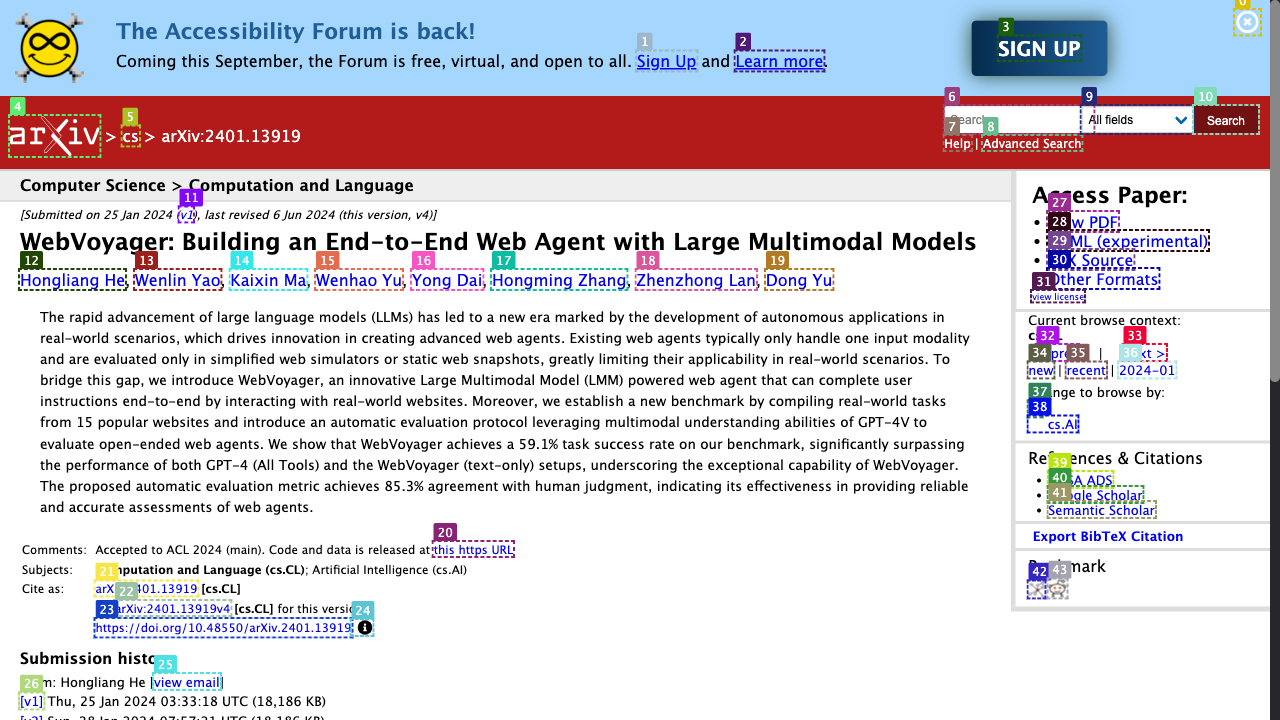

Final response: The WebVoyager paper introduces an innovative web agent powered by a Large Multimodal Model (LMM) that can complete user instructions end-to-end by interacting with real-world websites. It leverages multimodal understanding abilities of GPT-4V to evaluate open-ended web agents and sets a new benchmark by compiling tasks from 15 popular websites. The evaluation shows that WebVoyager achieves a 59.1% task success rate and performs significantly better than text-only setups, achieving 85.3% agreement with human judgment.


Failed to batch ingest runs: LangSmithConnectionError("Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. ConnectionError(ProtocolError('Connection aborted.', TimeoutError('The write operation timed out')))")
Failed to batch ingest runs: LangSmithConnectionError("Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. ConnectionError(ProtocolError('Connection aborted.', TimeoutError('The write operation timed out')))")
Failed to batch ingest runs: LangSmithConnectionError("Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. ConnectionError(ProtocolError('Connection aborted.', TimeoutError('The write operation timed out')))")
Failed to batch ingest runs: LangSmithConnectionError("Connection error caused failure to POST

In [28]:
res = await call_agent("Could you explain the WebVoyager paper (on arxiv)?", page)
print(f"Final response: {res}")

1. Click: ['20']
2. retry: Could not parse LLM Output: Thought: To find and explain the XKCD comic, I need to locate the appropriate link or section related to the comic on this webpage. None are immediately visible, so the next action would be to search for the comic or relevant link.

Action: Type 40; XKCD comic

Then the User will provide:
Observation: {A labeled screenshot Given by User}
3. Click: ['62']
4. Click: ['62']
5. Click: ['19']
6. Click: ['24']
7. Google: None
8. Type: ['6', "today's XKCD comic"]
9. Click: ['6']
10. Click: ['17']
11. ANSWER;: ["Today's XKCD comic is a play on the concept of the periodic table of elements, which in modern science lists chemical elements like Hydrogen, Carbon, and Oxygen. Instead of these, the comic uses the classical elements from ancient philosophy: Air, Earth, Fire, and Water. The humor comes from applying an old, outdated framework to a modern scientific tool, highlighting the contrast between ancient and modern understandings of the na

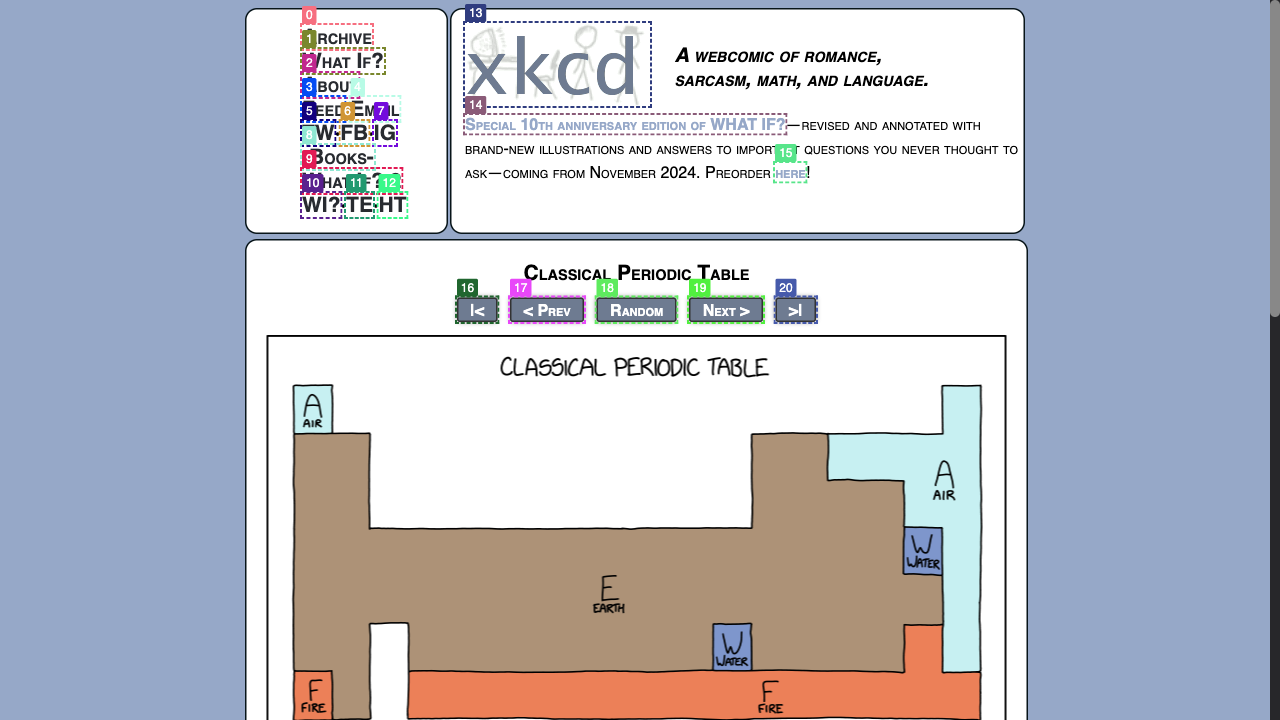

Final response: Today's XKCD comic is a play on the concept of the periodic table of elements, which in modern science lists chemical elements like Hydrogen, Carbon, and Oxygen. Instead of these, the comic uses the classical elements from ancient philosophy: Air, Earth, Fire, and Water. The humor comes from applying an old, outdated framework to a modern scientific tool, highlighting the contrast between ancient and modern understandings of the natural world.


In [29]:
res = await call_agent(
    "Please explain the today's XKCD comic for me. Why is it funny?", page
)
print(f"Final response: {res}")

1. Click: ['0']
2. Click: ['2']
3. Google: None
4. Type: ['6', 'latest blog posts from LangChain']
5. Click: ['0']
6. Type: ['6', 'latest blog posts from LangChain']
7. Click: ['17']
8. Click: ['1']
9. retry: Could not parse LLM Output: Thought: The page displays several blog posts from LangChain. To identify the latest blog posts, I will examine the titles of the posts.

Action: ANSWER; The latest blog posts from LangChain are:
1. "Few-shot prompting to improve tool-calling performance"
2. "Improving core tool interfaces and docs in LangChain"
3. "Announcing LangGraph v0.1 & LangGraph Cloud: Running agents at scale, reliably"
10. Click: ['11']
11. Click: ['1']
12. retry: Could not parse LLM Output: Thought: The latest blog posts are titled "Few-shot prompting to improve tool-calling performance," "Improving core tool interfaces and docs in LangChain," and "Announcing LangGraph v0.1 & LangGraph Cloud: Running agents at scale, reliably."

Action: ANSWER; The latest blog posts from LangC

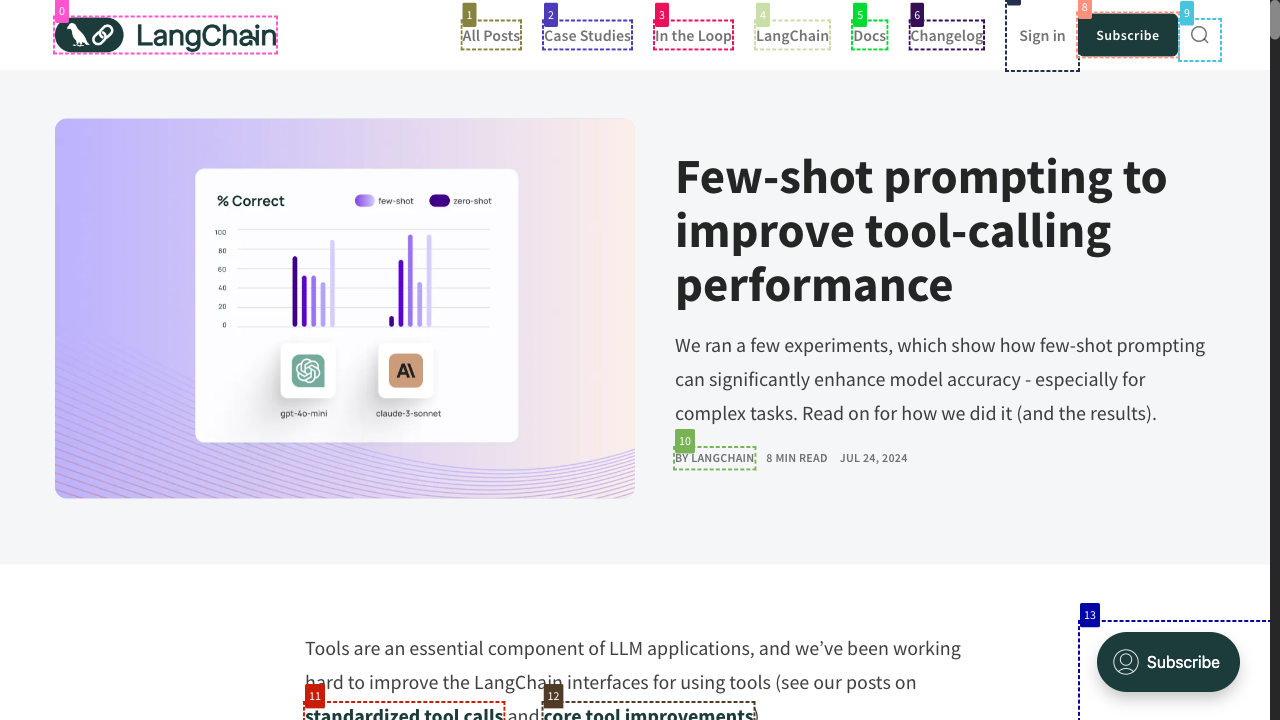

Final response: The latest blog post from LangChain is titled "Few-shot prompting to improve tool-calling performance."


In [30]:
res = await call_agent("What are the latest blog posts from langchain?", page)
print(f"Final response: {res}")

1. Google: None
2. Type: ['6', 'Google Maps']
3. Click: ['20']
4. Click: ['1']
5. Click: ['0']
6. Click: ['0']
7. Click: ['0']
8. Click: ['0']
9. Click: ['0']
10. Click: ['0']
11. Click: ['0']
12. Click: ['0']
13. Click: ['0']
14. Click: ['0']
15. Click: ['0']
16. Click: ['0']
17. Click: ['0']
18. Click: ['0']
19. Click: ['0']
20. Click: ['0']
21. Click: ['0']
22. Click: ['1']
23. Click: ['0']
24. Click: ['0']
25. Click: ['0']
26. Click: ['0']
27. Click: ['1']
28. Click: ['0']
29. Click: ['0']
30. Click: ['1']
31. Click: ['1']
32. Click: ['0']
33. Click: ['1']
34. Click: ['0']
35. Click: ['0']
36. Click: ['0']
37. Click: ['0']
38. Click: ['0']


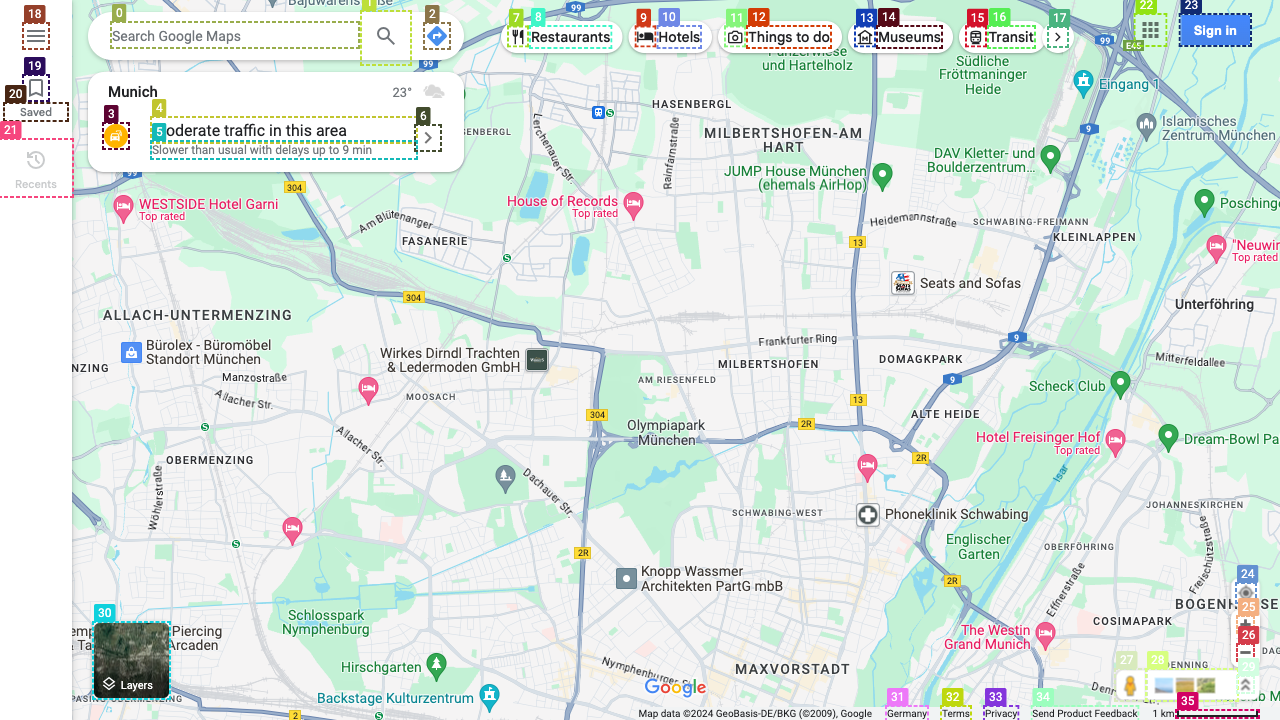

Exception ignored in: <function BaseEventLoop.__del__ at 0x10d23afc0>
Traceback (most recent call last):
  File "/Users/kenanagyel/anaconda3/envs/langchain/lib/python3.12/asyncio/base_events.py", line 725, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/Users/kenanagyel/anaconda3/envs/langchain/lib/python3.12/asyncio/base_events.py", line 722, in is_closed
    return self._closed
           ^^^^^^^^^^^^
AttributeError: '_UnixSelectorEventLoop' object has no attribute '_closed'
Exception ignored in: <function BaseEventLoop.__del__ at 0x10d23afc0>
Traceback (most recent call last):
  File "/Users/kenanagyel/anaconda3/envs/langchain/lib/python3.12/asyncio/base_events.py", line 725, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/Users/kenanagyel/anaconda3/envs/langchain/lib/python3.12/asyncio/base_events.py", line 722, in is_closed
    return self._closed
           ^^^^^^^^^^^^
AttributeError: '_UnixSelectorEventLoop' object has n

CancelledError: 

In [31]:
res = await call_agent(
    "Could you check google maps to see when i should leave to get to SFO by 7 o'clock? starting from SF downtown.",
    page,
)
print(f"Final response: {res}")